# Introduction to the `scikit-learn` API

In [1]:
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# A NEW THING!!!
from sklearn.linear_model import LinearRegression

In [2]:
def create_usgs_url(site_no, begin_date, end_date):
    return (f'https://waterdata.usgs.gov/nwis/dv?'
        f'cb_00060=on&format=rdb&referred_module=sw&'
        f'site_no={site_no}&'
        f'begin_date={begin_date}&'
        f'end_date={end_date}')

def open_usgs_data(site, begin_date, end_date):
    url = create_usgs_url((site), begin_date, end_date)
    response = urllib.request.urlopen(url)
    df = pd.read_table(
        response, comment='#', skipfooter=1, delim_whitespace=True,
        names=['agency', 'site', 'date', 'streamflow', 'quality_flag'],
        index_col=2, parse_dates=True).iloc[2:]
    df['streamflow'] = df['streamflow'].astype(np.float64)
    df.index = pd.DatetimeIndex(df.index)
    return df

def open_daymet_data(lat, lon, begin_date, end_date):
    args = {'lat':  lat, 'lon': lon, 'format': 'csv',
            'start': begin_date, 'end': end_date}
    query = urllib.parse.urlencode(args)
    url = f"https://daymet.ornl.gov/single-pixel/api/data?{query}"
    response = urllib.request.urlopen(url)
    df = pd.read_csv(response, header=6)
    datestring = (df['year'].astype(str) + df['yday'].astype(str))
    dates = pd.to_datetime(datestring, format='%Y%j')
    df.index = pd.DatetimeIndex(dates)
    return df

In [3]:
site = '09506000'
begin_date = '2000-09-25'
end_date = '2022-09-25'
lat = 34.4483605
lon = -111.7898705

daymet_df = open_daymet_data(lat, lon, begin_date, end_date)
daymet_df.head()
verde_df = open_usgs_data(site, begin_date, end_date)
daymet_df = daymet_df.reindex(verde_df.index)
daymet_df['streamflow'] = verde_df['streamflow']
df = daymet_df
df.head()

/tmp/ipykernel_260660/263521254.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_table(


,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),streamflow
date,,,,,,,,,,
2000-09-25,2000.0,269.0,42469.79,0.0,468.71,0.0,33.19,8.82,812.16,71.0
2000-09-26,2000.0,270.0,42337.25,0.0,400.17,0.0,33.34,14.15,1270.29,73.0
2000-09-27,2000.0,271.0,42204.86,0.0,403.44,0.0,35.60,15.39,1356.50,79.0
2000-09-28,2000.0,272.0,42072.64,0.0,413.88,0.0,35.91,14.69,1225.75,89.0
2000-09-29,2000.0,273.0,41940.63,0.0,385.53,0.0,35.72,16.18,1410.96,89.0


[]

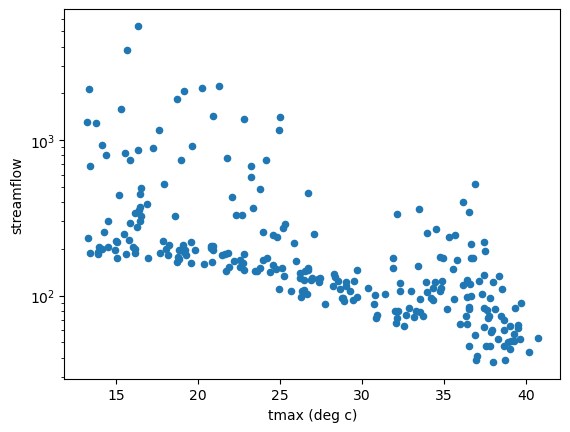

In [4]:
df_monthly = df.resample('M').mean()
df_monthly = df_monthly.dropna()
df_monthly.plot.scatter(x='tmax (deg c)', y='streamflow')
plt.semilogy()

In [5]:
lm = LinearRegression()
x = df_monthly[['tmax (deg c)']]
y = df_monthly[['streamflow']]
lm.fit(x, y)
xfit = np.linspace(np.min(x), np.max(x), 20).reshape(-1, 1)
yfit = lm.predict(xfit)

/home/bzq/miniconda3/envs/pywwc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/bzq/miniconda3/envs/pywwc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/bzq/miniconda3/envs/pywwc/lib/python3.11/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


[]

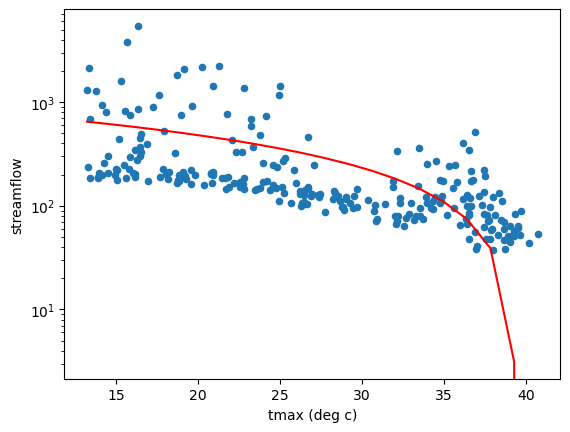

In [6]:
df_monthly.plot.scatter(x='tmax (deg c)', y='streamflow')
plt.plot(xfit, yfit, color='red')
plt.semilogy()

In [7]:
log_lm = LinearRegression()
x = df_monthly[['tmax (deg c)']]
ylog = np.log(df_monthly[['streamflow']])
log_lm.fit(x, ylog)

LinearRegression()

In [8]:
xfit = np.linspace(np.min(x), np.max(x), 20).reshape(-1, 1)
# Remember we fit on log values, so we need to transform
# from log(streamflow) -> streamflow via the `np.exp` call
yfit_log = np.exp(log_lm.predict(xfit))

/home/bzq/miniconda3/envs/pywwc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/bzq/miniconda3/envs/pywwc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/bzq/miniconda3/envs/pywwc/lib/python3.11/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


[]

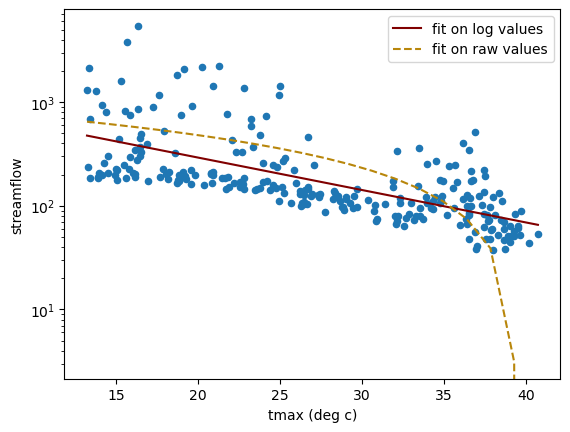

In [9]:
df_monthly.plot.scatter(x='tmax (deg c)', y='streamflow')
plt.plot(xfit, yfit_log, color='maroon', label='fit on log values')
plt.plot(xfit, yfit, color='darkgoldenrod', linestyle='--', label='fit on raw values')
plt.legend()
plt.semilogy()

In [10]:
log_score = log_lm.score(x, ylog)
reg_score = log_lm.score(x, y)

print(log_score, reg_score)

0.4443528547288781 -0.3079821677725352


In [11]:
c = log_lm.coef_
i = log_lm.intercept_
print(c, i)

[[-0.07198031]] [7.11403618]
